In [ ]:
# %% [markdown]
# # Arbitrage Data Analysis
# 
# This notebook is designed to analyze the data collected by the Binance-Uniswap arbitrage bot, which is stored in the `arbitrage_results_1000.csv` file. The goal is to extract meaningful statistics and visualize the results to understand the profitability, frequency, and characteristics of the arbitrage opportunities found.
# 
# **Analysis Steps:**
# 1.  **Load and Prepare Data:** Import the CSV data and perform initial cleaning.
# 2.  **Descriptive Statistics:** Calculate summary statistics for key metrics.
# 3.  **Profitability Analysis:** Focus on profitable trades to understand their distribution.
# 4.  **Data Visualization:** Create plots to visualize trends, compare pairs, and understand the impact of various factors like gas fees.

# %%
# Step 1: Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set plot style for better aesthetics
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['figure.autolayout'] = True

# %%
# Step 2: Load and Prepare the Data
try:
    # Make sure the filename matches the one generated by your bot
    df = pd.read_csv("arbitrage_results_1000.csv")
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: 'arbitrage_results_1000.csv' not found.")
    print("Please make sure the results file is in the same directory as this notebook and the filename is correct.")
    df = pd.DataFrame() # Create an empty dataframe to avoid further errors

if not df.empty:
    # Convert timestamp to a readable datetime format
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    
    # Calculate price difference percentage for context
    df['price_diff_percent'] = ((df['uniswap_actual_price'] - df['binance_actual_price']) / df['binance_actual_price']) * 100

    print("Data prepared for analysis.")
    df.head()


Data loaded successfully.
Data prepared for analysis.


In [6]:
# %% [markdown]
# ## 3. General Statistics
# 
# First, let's look at the overall statistics for the key numerical columns to get a high-level overview of the data.

# %%
if not df.empty:
    # Display summary statistics for important columns
    stats = df[['margin', 'profit', 'profit_stablecoin', 'gas_fee_eth', 'price_diff_percent']].describe()
    print("Overall Descriptive Statistics:")
    display(stats)

Overall Descriptive Statistics:


,margin,profit,profit_stablecoin,gas_fee_eth,price_diff_percent
count,381198.000000,381198.000000,381198.000000,381198.000000,381198.000000
mean,-0.003341,-2.134436,-3.359581,0.000171,-0.009818
std,0.005692,3.095796,5.805420,0.000177,0.640084
min,-0.085623,-25.999819,-85.638024,0.000029,-8.461727
25%,-0.004420,-2.983233,-4.429009,0.000073,-0.134489
50%,-0.001968,-1.016531,-1.969644,0.000112,-0.003595
75%,-0.000908,-0.003487,-0.907974,0.000190,0.124806
max,0.009515,9.385760,9.416360,0.002188,7.912445


In [7]:
# %% [markdown]
# ## 4. Profitability Analysis
# 
# Now, let's filter the data to look only at opportunities that were theoretically profitable (i.e., `profit_stablecoin > 0`). This helps us understand the nature of the profitable trades themselves.

# %%
if not df.empty:
    # Filter for profitable trades
    profitable_df = df[df['profit_stablecoin'] > 0].copy()

    if not profitable_df.empty:
        print(f"Found {len(profitable_df)} profitable opportunities out of {len(df)} total calculations ({len(profitable_df)/len(df):.2%}).\n")
        
        # Get statistics for profitable trades
        profitable_stats = profitable_df[['margin', 'profit_stablecoin', 'gas_fee_quote']].describe()
        print("Descriptive Statistics for Profitable Trades:")
        display(profitable_stats)
    else:
        print("No profitable opportunities were found in the dataset.")

Found 5626 profitable opportunities out of 381198 total calculations (1.48%).

Descriptive Statistics for Profitable Trades:


,margin,profit_stablecoin,gas_fee_quote
count,5.626000e+03,5626.000000,5.626000e+03
mean,2.723281e-04,0.272142,2.052257e-01
std,4.304433e-04,0.429451,1.540132e-01
min,4.700000e-09,0.000005,8.412000e-07
25%,6.939680e-05,0.069362,1.344058e-01
50%,1.641542e-04,0.164095,1.869582e-01
75%,3.130048e-04,0.312895,2.822253e-01
max,9.514523e-03,9.416360,1.761738e+00


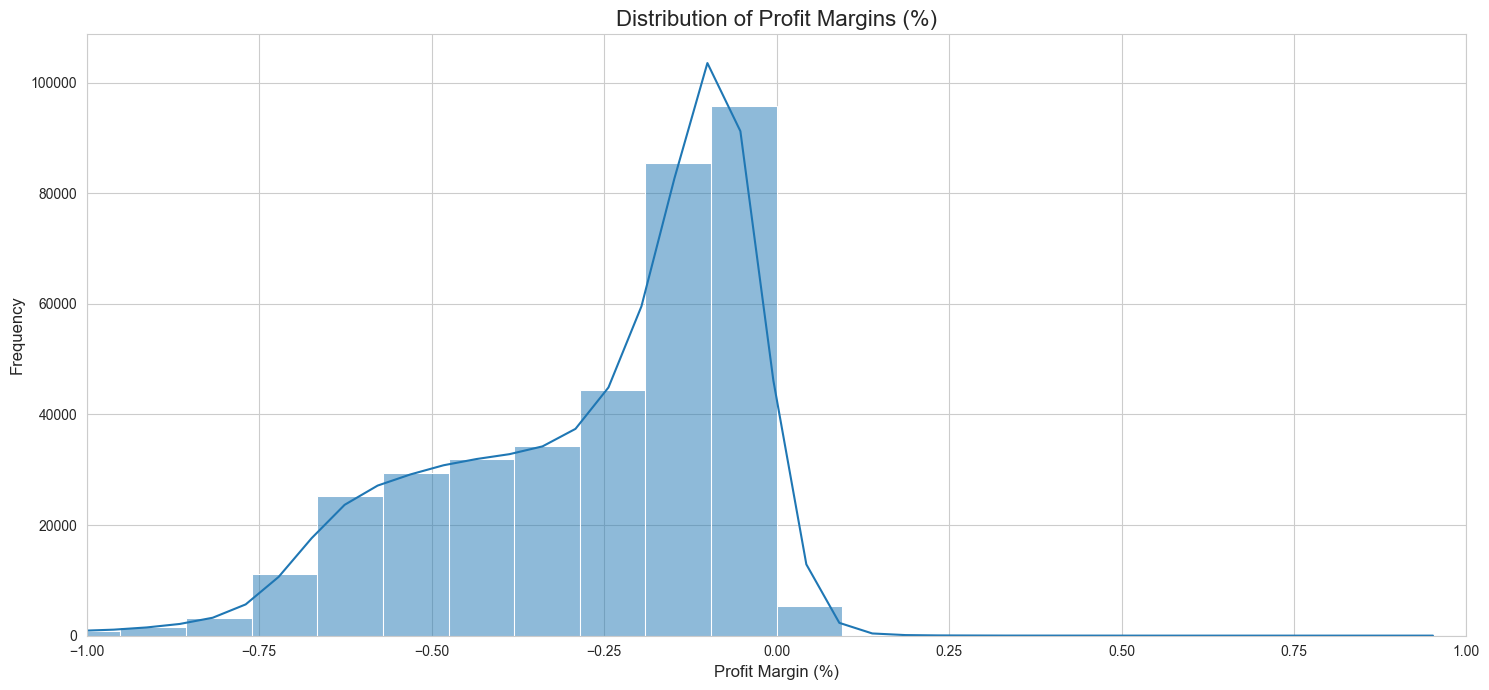

In [8]:
# %% [markdown]
# ## 5. Data Visualization
# 
# Visualizing the data is the best way to uncover trends and insights that are not apparent from summary statistics alone.

# %% [markdown]
# ### 5.1. Distribution of Profit Margins
# This histogram shows the distribution of profit margins. A significant concentration around zero is expected, with a long tail representing rare, larger opportunities. We'll plot a narrow range to see the detail around zero.

# %%
if not df.empty:
    plt.figure(figsize=(15, 7))
    sns.histplot(df['margin'] * 100, bins=100, kde=True)
    plt.title('Distribution of Profit Margins (%)', fontsize=16)
    plt.xlabel('Profit Margin (%)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    # Focus on the area where most opportunities lie
    plt.xlim(-1, 1)
    plt.show()

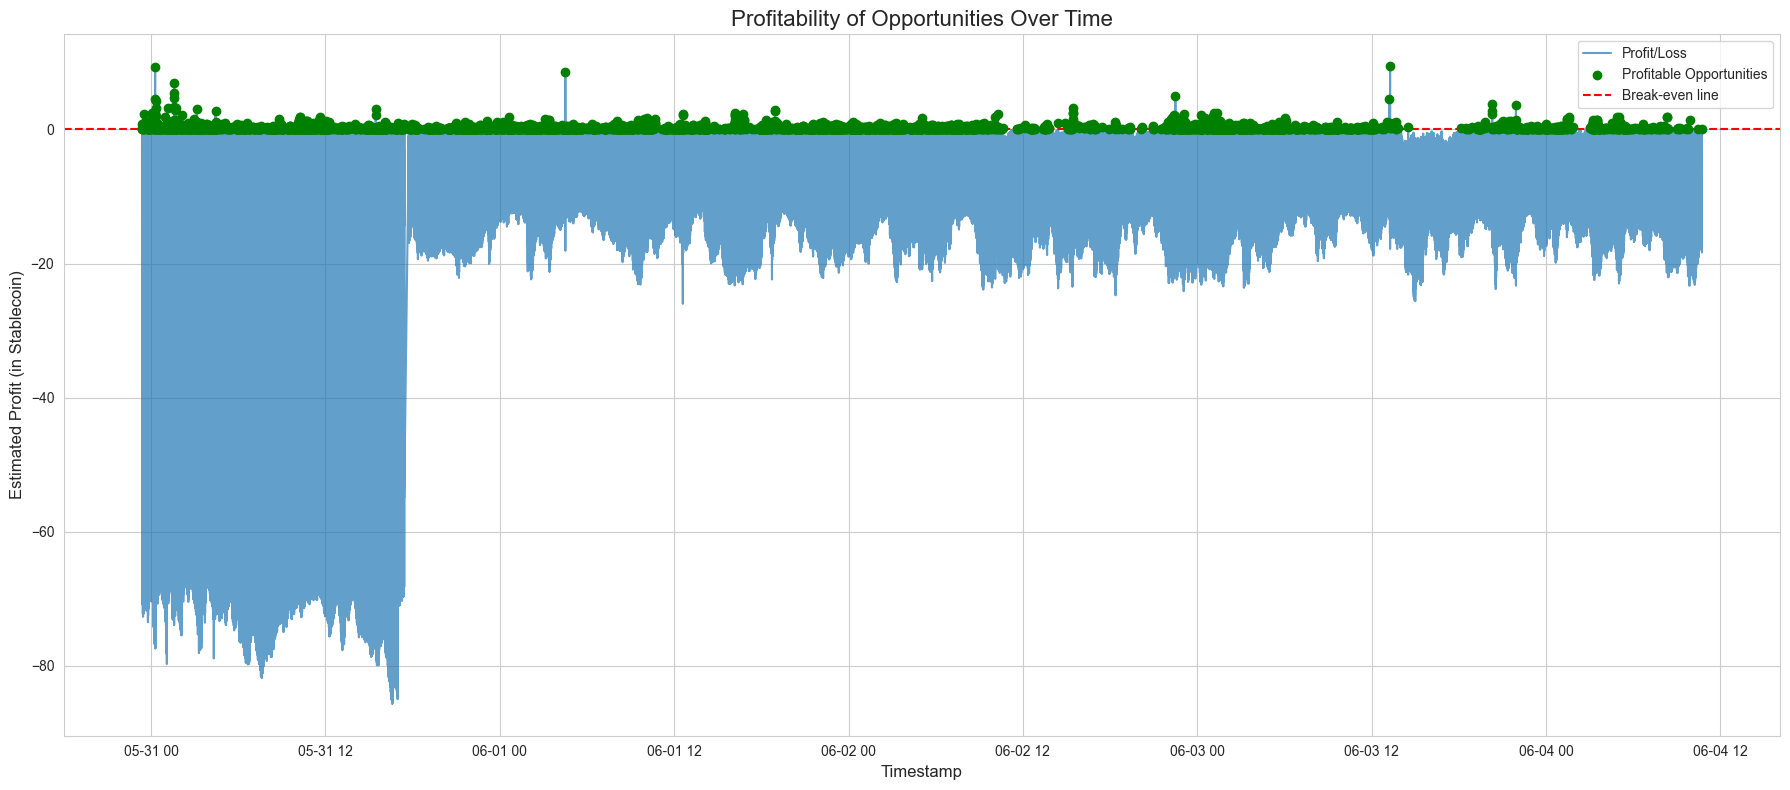

In [9]:
# %% [markdown]
# ### 5.2. Profitability Over Time
# This plot shows the estimated profit of each opportunity over time. It can help identify if arbitrage opportunities appear more frequently during specific periods of high volatility.

# %%
if not df.empty:
    plt.figure(figsize=(18, 8))
    plt.plot(df['timestamp'], df['profit_stablecoin'], label='Profit/Loss', alpha=0.7)
    # Highlight profitable opportunities
    plt.scatter(profitable_df['timestamp'], profitable_df['profit_stablecoin'], color='green', label='Profitable Opportunities', zorder=5)
    
    plt.title('Profitability of Opportunities Over Time', fontsize=16)
    plt.xlabel('Timestamp', fontsize=12)
    plt.ylabel('Estimated Profit (in Stablecoin)', fontsize=12)
    plt.axhline(0, color='red', linestyle='--', label='Break-even line')
    plt.legend()
    plt.show()

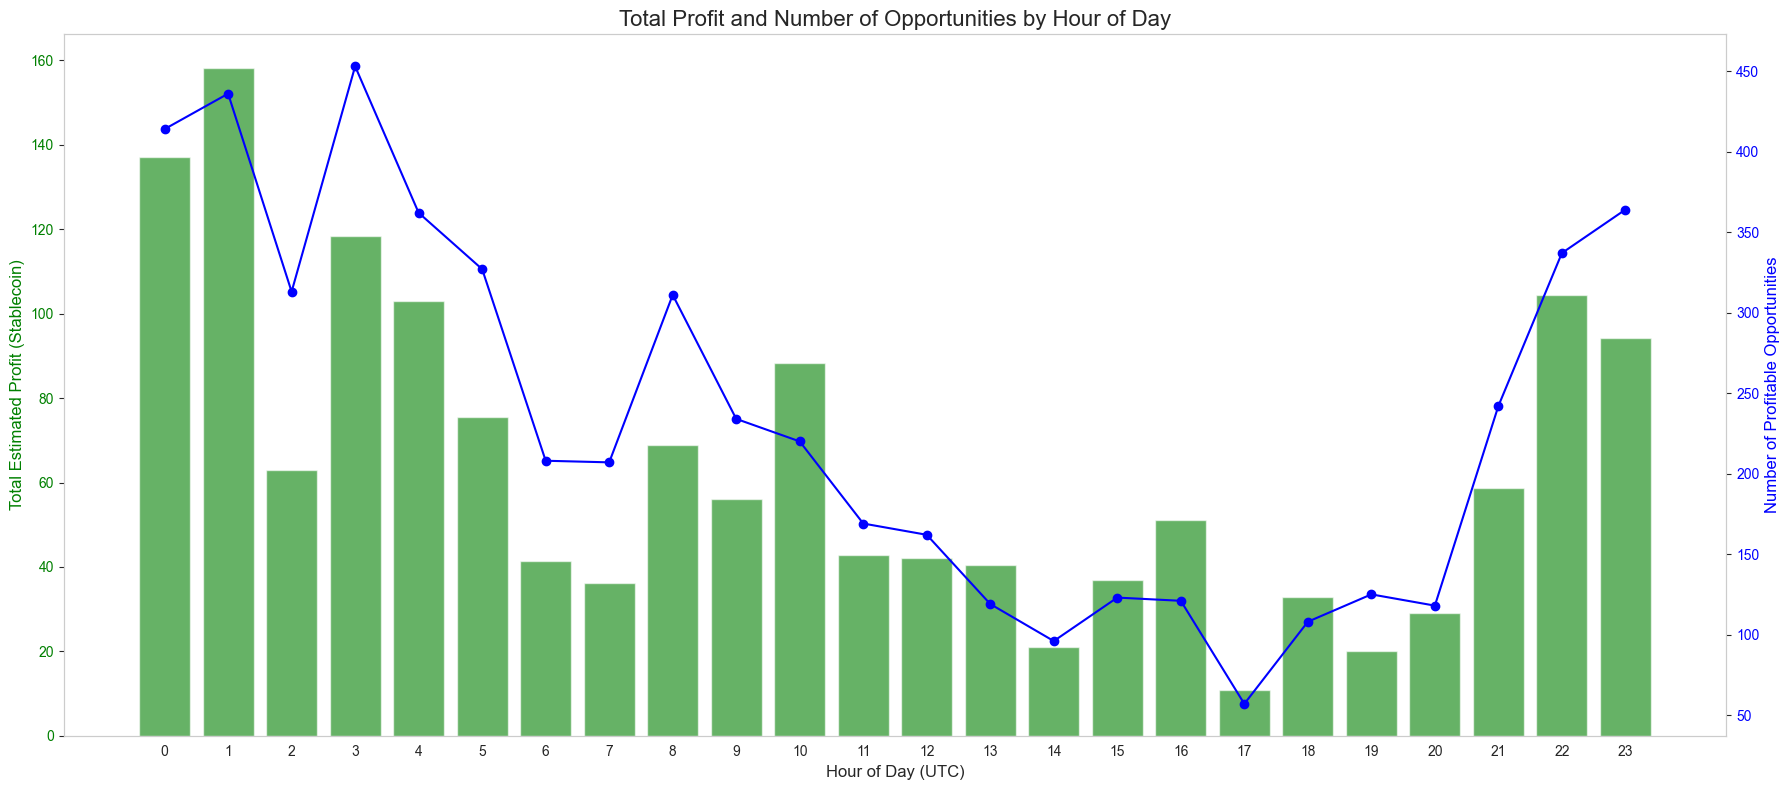

In [14]:
# %% [markdown]
# ### 5.3. Profitability by Hour of Day
# This analysis aggregates profitable opportunities by the hour of the day they occurred. This can reveal intraday patterns, such as whether opportunities are more frequent or larger during specific times (e.g., during the opening of major stock markets).

# %%
if 'profitable_df' in locals() and not profitable_df.empty:
    # Extract the hour from the timestamp
    profitable_df['hour_of_day'] = profitable_df['timestamp'].dt.hour
    
    # Group by hour and calculate total profit and number of opportunities
    hourly_analysis = profitable_df.groupby('hour_of_day')['profit_stablecoin'].agg(['sum', 'count'])
    hourly_analysis = hourly_analysis.reindex(range(24), fill_value=0) # Ensure all 24 hours are present

    fig, ax1 = plt.subplots(figsize=(18, 8))
    
    # Plot the total profit sum on the primary y-axis
    ax1.set_title('Total Profit and Number of Opportunities by Hour of Day', fontsize=16)
    ax1.set_xlabel('Hour of Day (UTC)', fontsize=12)
    ax1.set_ylabel('Total Estimated Profit (Stablecoin)', fontsize=12, color='g')
    ax1.bar(hourly_analysis.index, hourly_analysis['sum'], color='g', alpha=0.6, label='Total Profit')
    ax1.tick_params(axis='y', labelcolor='g')
    
    # Create a secondary y-axis to plot the count of opportunities
    ax2 = ax1.twinx()
    ax2.set_ylabel('Number of Profitable Opportunities', fontsize=12, color='b')
    ax2.plot(hourly_analysis.index, hourly_analysis['count'], color='b', marker='o', linestyle='-', label='Opportunity Count')
    ax2.tick_params(axis='y', labelcolor='b')

    ax1.grid(False)
    ax2.grid(False)
    
    fig.tight_layout()
    plt.xticks(range(24))
    plt.show()

/var/folders/27/ck8fkqh11018m9kgt4qrygg40000gn/T/ipykernel_25287/1152475343.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_pairs_analysis.index, y=top_pairs_analysis['sum'], palette='viridis', ax=ax1, alpha=0.7)
/var/folders/27/ck8fkqh11018m9kgt4qrygg40000gn/T/ipykernel_25287/1152475343.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right")


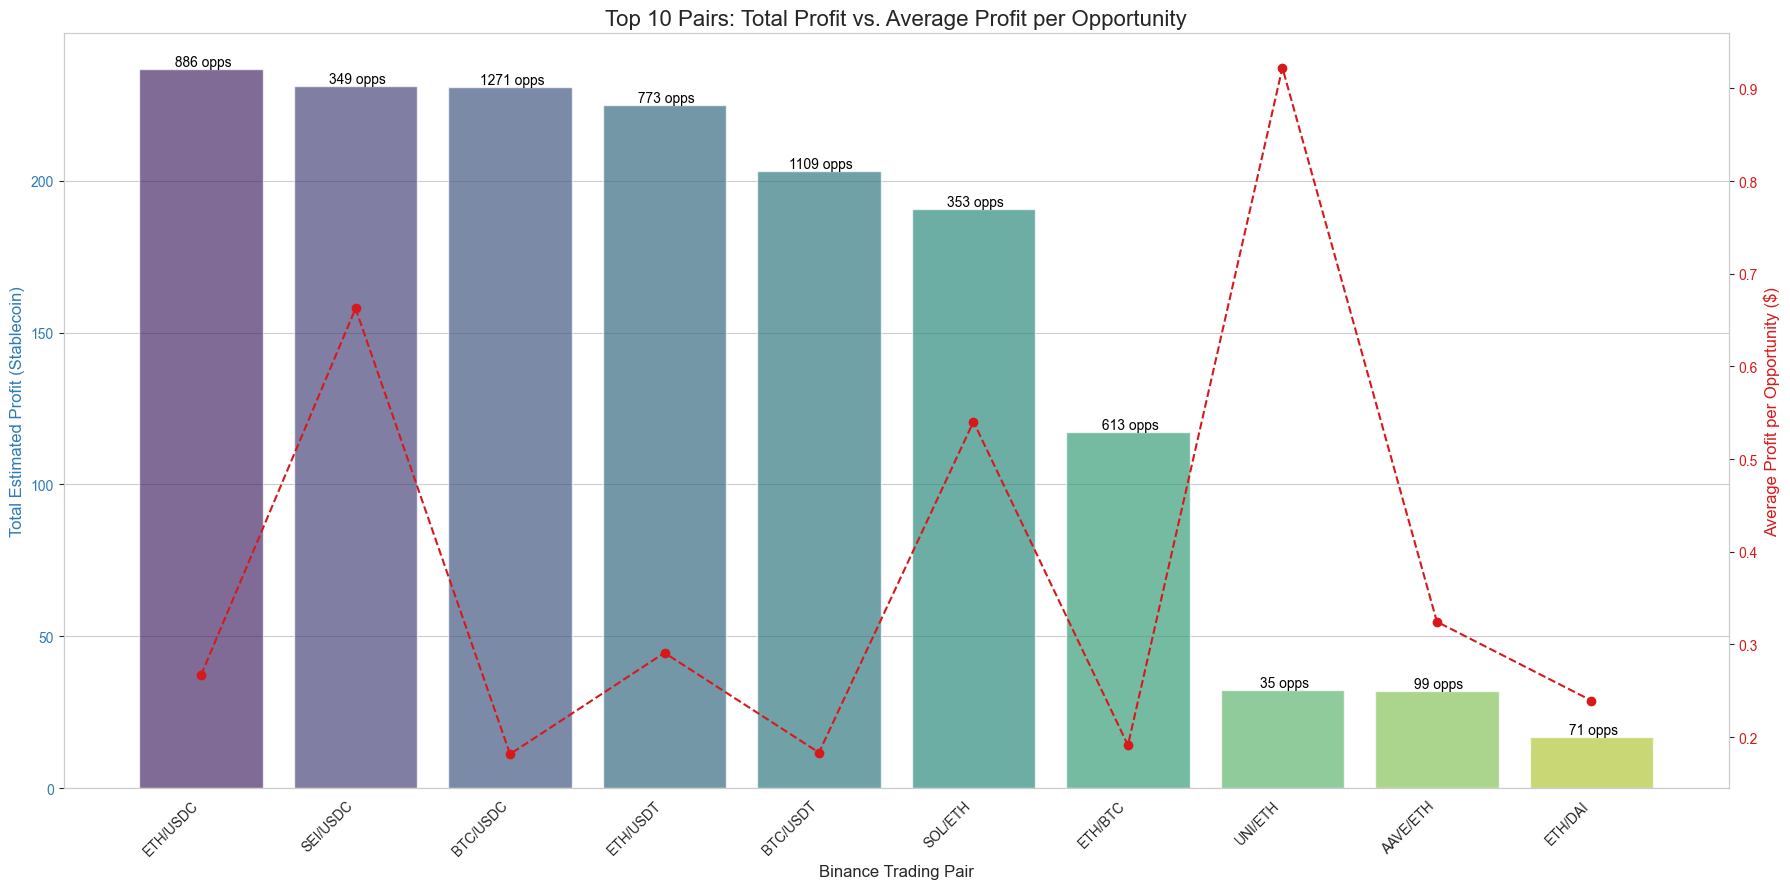

In [17]:
# %% [markdown]
# ### 5.3. Top 10 Most Profitable Pairs
# This bar chart shows which trading pairs generated the highest cumulative profit. This helps identify the most consistently lucrative markets to monitor.

# %%
if 'profitable_df' in locals() and not profitable_df.empty:
    # Group by trading pair and get the sum, count, and mean of profits
    top_pairs_analysis = profitable_df.groupby('binance_pair')['profit_stablecoin'].agg(['sum', 'count', 'mean']).sort_values(by='sum', ascending=False).head(10)
    
    # Create the plot with two y-axes
    fig, ax1 = plt.subplots(figsize=(18, 9))
    
    # Plot Total Profit (bars) on the primary y-axis
    sns.barplot(x=top_pairs_analysis.index, y=top_pairs_analysis['sum'], palette='viridis', ax=ax1, alpha=0.7)
    ax1.set_title('Top 10 Pairs: Total Profit vs. Average Profit per Opportunity', fontsize=16)
    ax1.set_xlabel('Binance Trading Pair', fontsize=12)
    ax1.set_ylabel('Total Estimated Profit (Stablecoin)', fontsize=12, color='#2c7bb6')
    ax1.tick_params(axis='y', labelcolor='#2c7bb6')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right")

    # Add text annotations for the opportunity count on each bar
    for i, (index, row) in enumerate(top_pairs_analysis.iterrows()):
        ax1.text(i, row['sum'], f" {row['count']:.0f} opps", color='black', ha='center', va='bottom', fontsize=10)
        
    # Create a secondary y-axis for the Average Profit
    ax2 = ax1.twinx()
    ax2.plot(top_pairs_analysis.index, top_pairs_analysis['mean'], color='#d7191c', marker='o', linestyle='--', label='Average Profit')
    ax2.set_ylabel('Average Profit per Opportunity ($)', fontsize=12, color='#d7191c')
    ax2.tick_params(axis='y', labelcolor='#d7191c')
    
    # Turn off the grid for the secondary axis to keep it clean
    ax2.grid(False)
    
    # Adjust layout
    fig.tight_layout()
    plt.show()

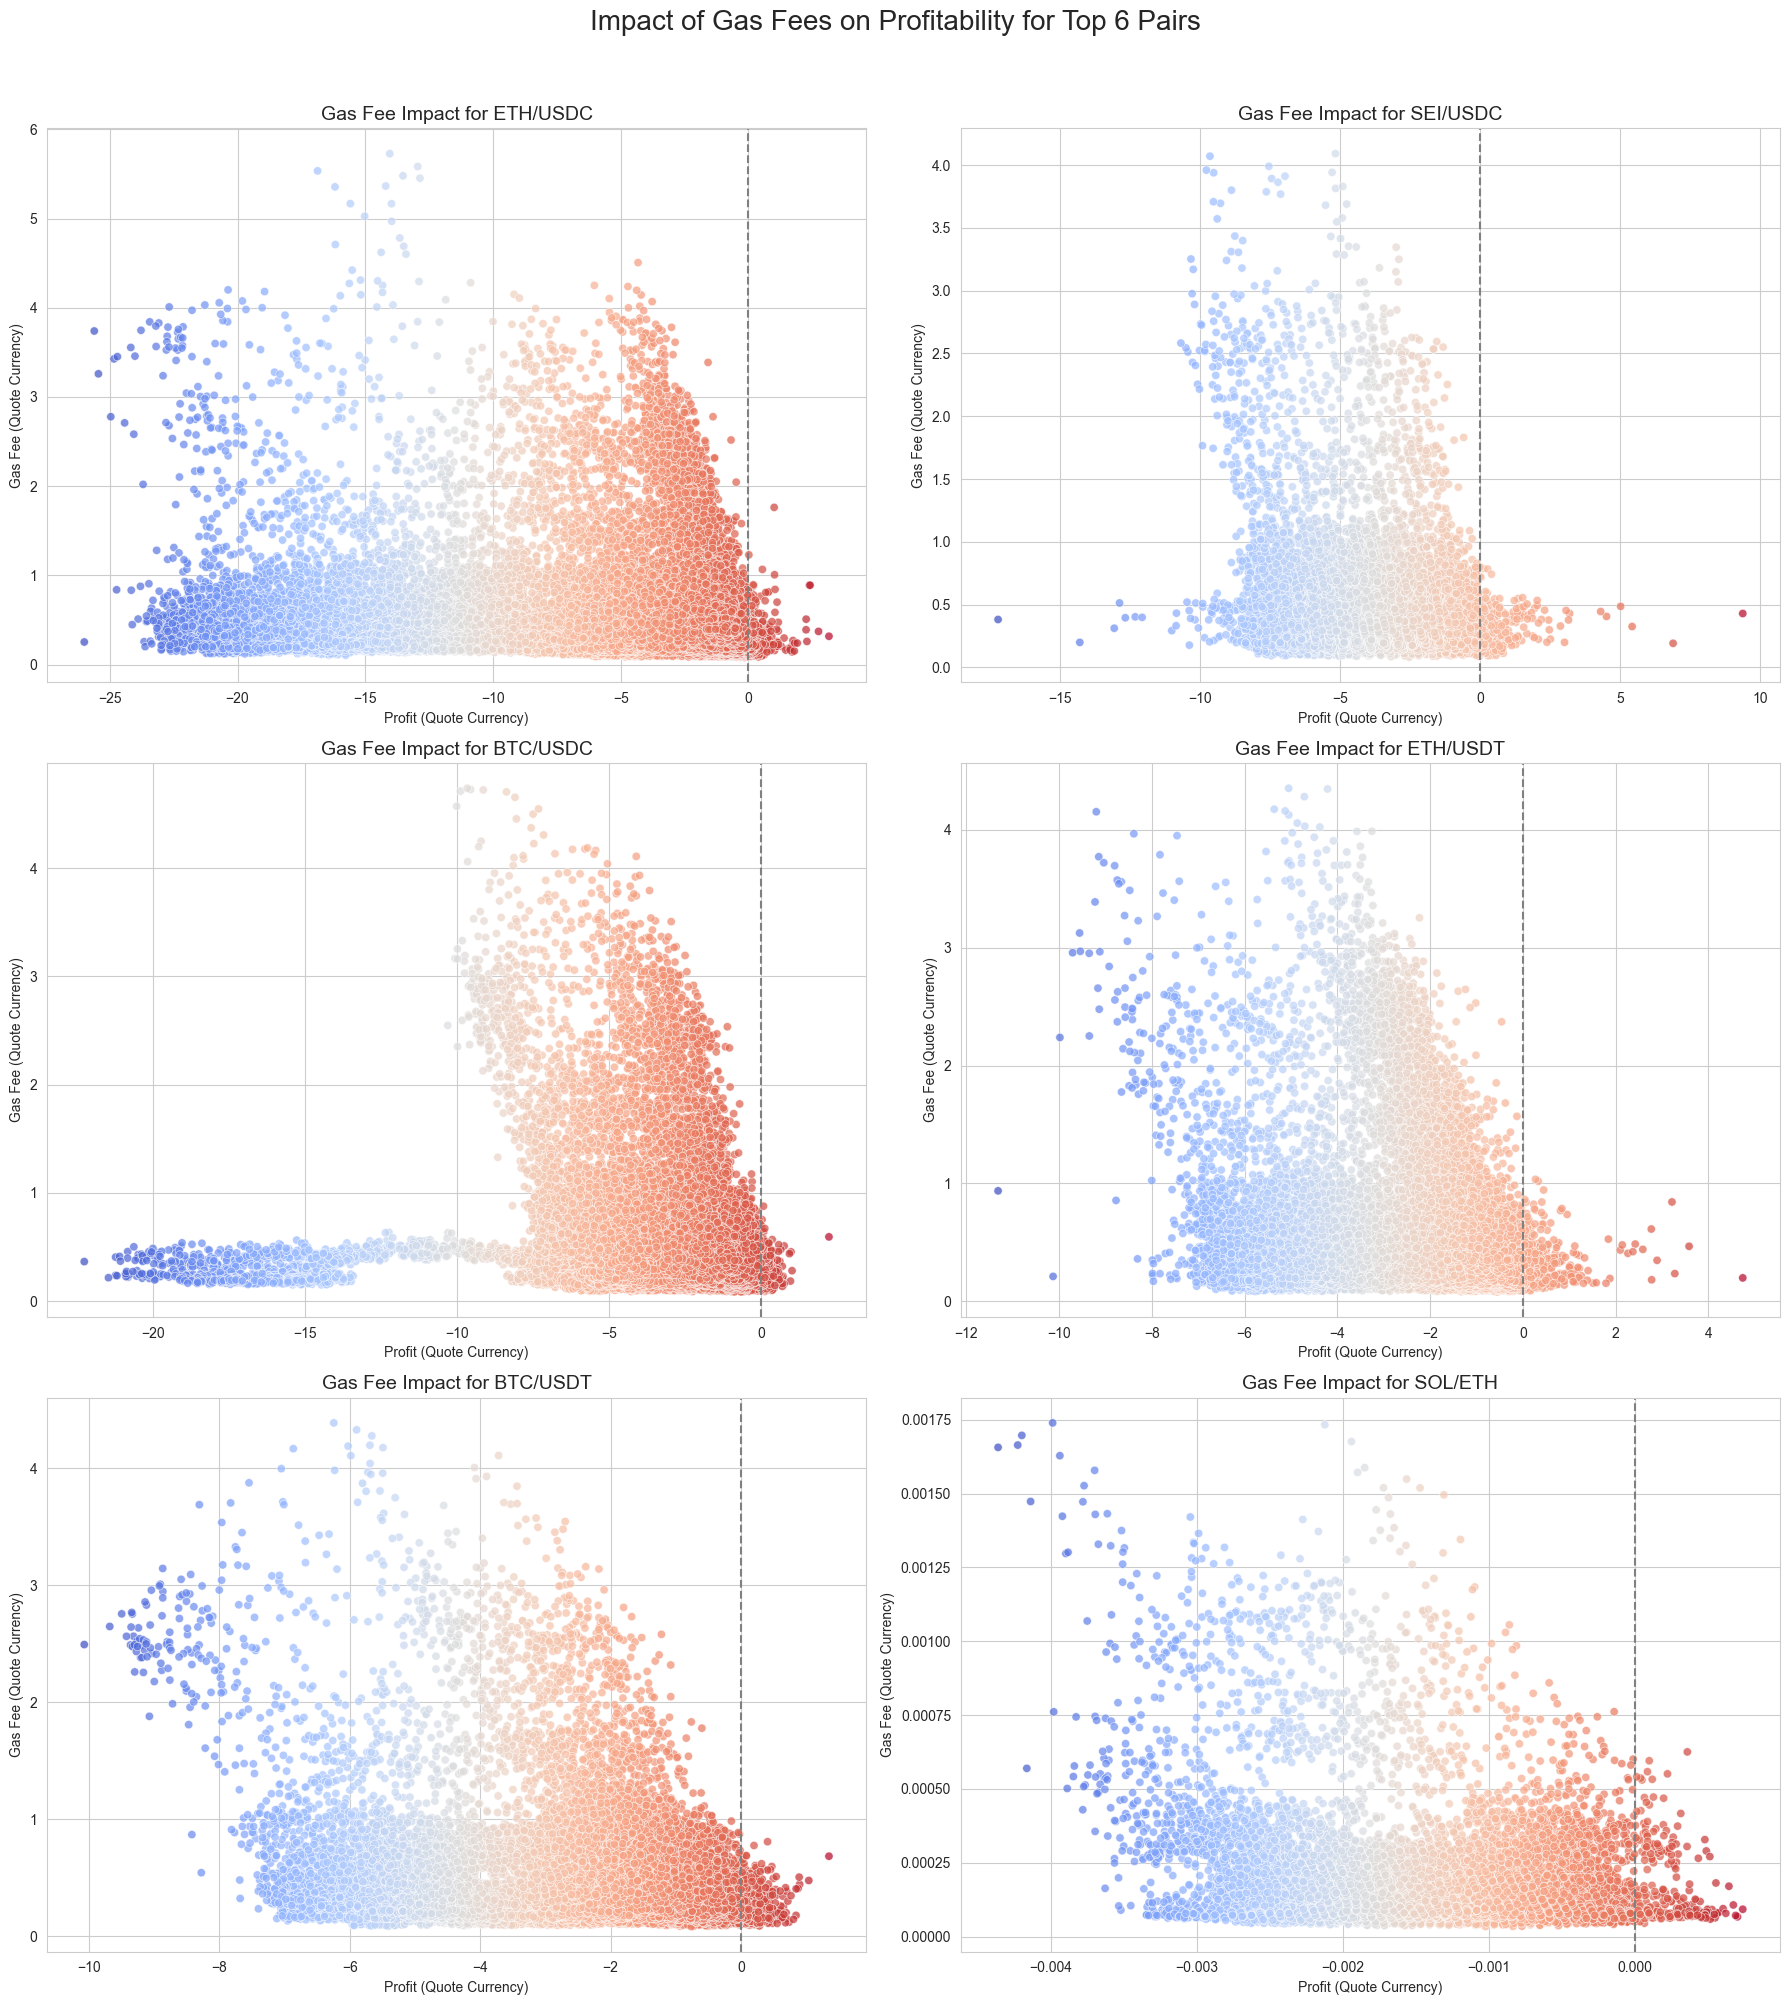

In [ ]:
# %% [markdown]
# ### 5.5. Gas Fee Impact Analysis for Top 6 Pairs
# This section breaks down the gas fee analysis for the top 6 most profitable pairs. It allows for a more granular view of how gas costs affect profitability for different assets, which may have varying levels of volatility and price points.

# %%
if not df.empty and 'profitable_df' in locals() and not profitable_df.empty:
    # Get the names of the top 6 pairs
    top_6_pairs = profitable_df.groupby('binance_pair')['profit_stablecoin'].sum().sort_values(ascending=False).head(6).index.tolist()
    
    fig, axes = plt.subplots(3, 2, figsize=(18, 20))
    axes = axes.flatten() # Flatten the 3x2 grid into a 1D array for easy iteration

    # Ensure gross_profit is calculated
    #if 'gross_profit' not in df.columns:
    #    df['gross_profit'] = df['profit'] + df['gas_fee_quote']

    for i, pair in enumerate(top_6_pairs):
        ax = axes[i]
        pair_df = df[df['binance_pair'] == pair]
        
        sns.scatterplot(data=pair_df, x='profit', y='gas_fee_quote', hue='profit', palette='coolwarm', alpha=0.7, ax=ax, legend=False)
        ax.set_title(f'Gas Fee Impact for {pair}', fontsize=14)
        ax.set_xlabel('Profit (Quote Currency)')
        ax.set_ylabel('Gas Fee (Quote Currency)')
        ax.axvline(0, color='grey', linestyle='--')

    # Hide any unused subplots
    for j in range(len(top_6_pairs), len(axes)):
        axes[j].set_visible(False)

    plt.suptitle('Impact of Gas Fees on Profitability for Top 6 Pairs', fontsize=20, y=1.0)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

/var/folders/27/ck8fkqh11018m9kgt4qrygg40000gn/T/ipykernel_25287/158492596.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pair_df, x='decision', y='profit_stablecoin', palette='pastel', ax=ax)
/var/folders/27/ck8fkqh11018m9kgt4qrygg40000gn/T/ipykernel_25287/158492596.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pair_df, x='decision', y='profit_stablecoin', palette='pastel', ax=ax)
/var/folders/27/ck8fkqh11018m9kgt4qrygg40000gn/T/ipykernel_25287/158492596.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pair_d

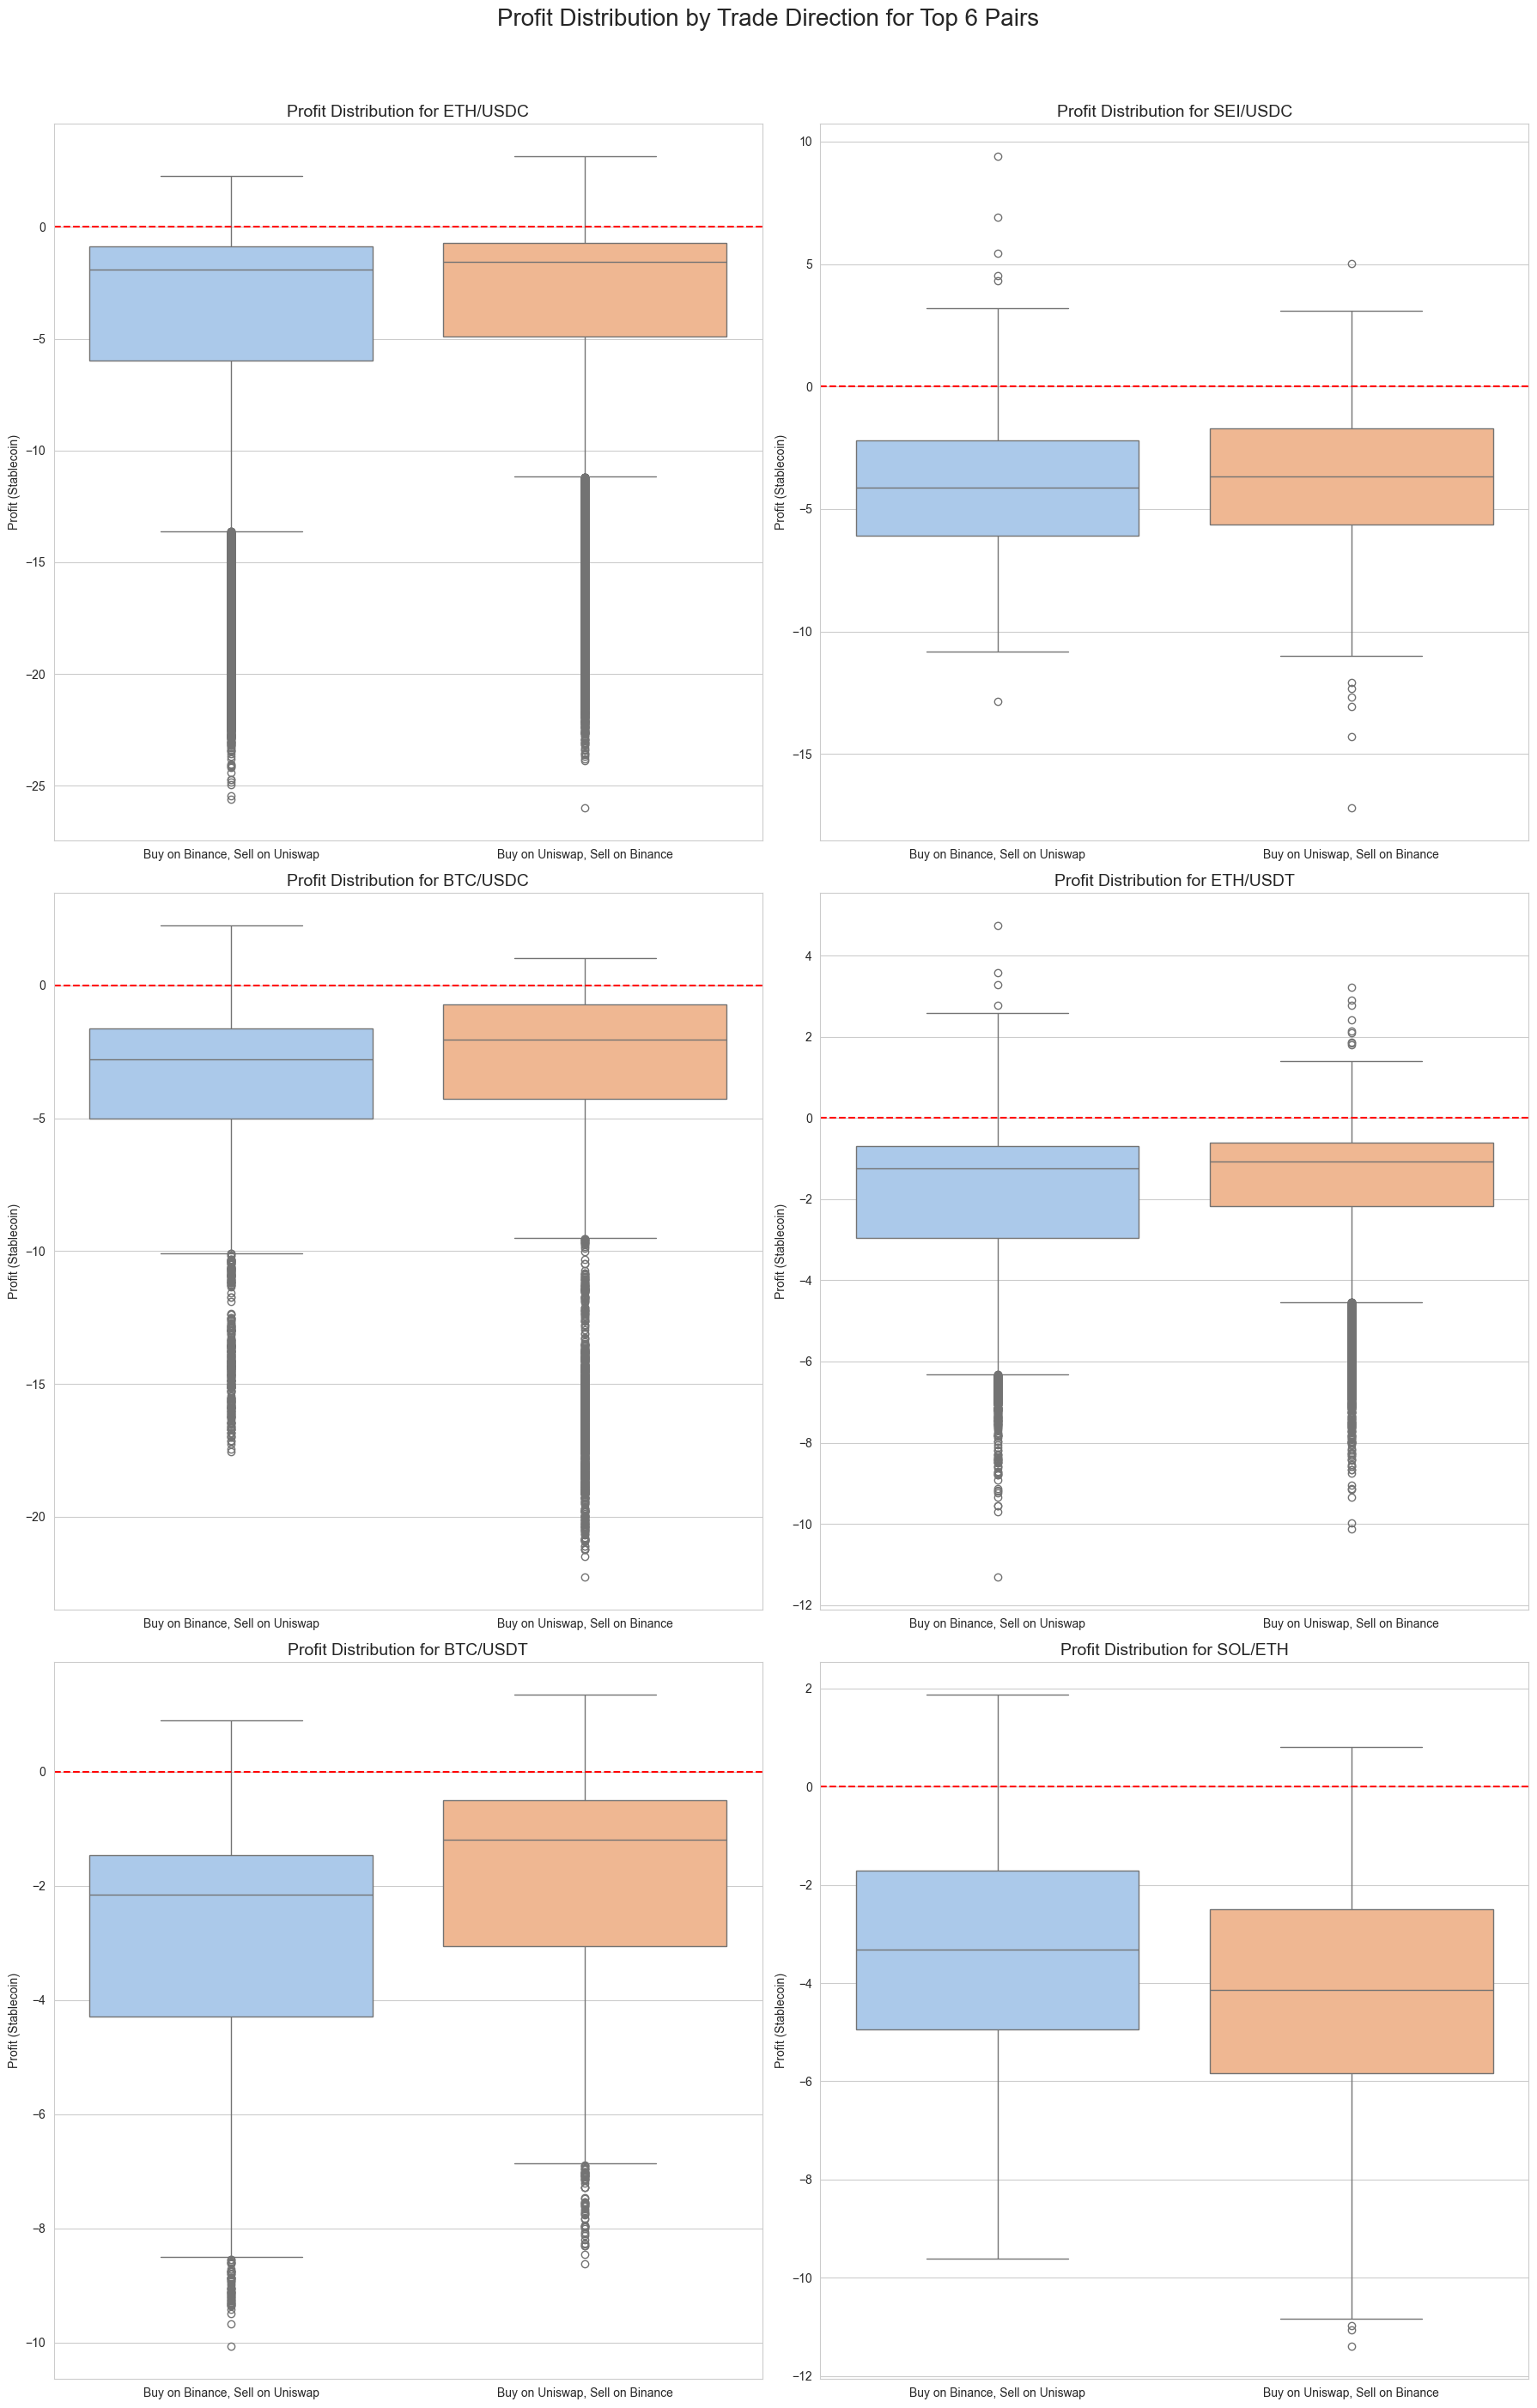

In [23]:
# %% [markdown]
# ### 5.8. Profit Distribution by Trade Direction for Top 6 Pairs
# This section provides a more detailed view by creating individual box plots for each of the top 6 most profitable pairs. This can help identify if certain pairs have a strong directional bias in their arbitrage opportunities.

# %%
if not df.empty and 'profitable_df' in locals() and not profitable_df.empty:
    # Get the names of the top 6 pairs
    top_6_pairs = profitable_df.groupby('binance_pair')['profit_stablecoin'].sum().sort_values(ascending=False).head(6).index.tolist()

    fig, axes = plt.subplots(3, 2, figsize=(18, 28))
    axes = axes.flatten() # Flatten the 3x2 grid for easy iteration

    for i, pair in enumerate(top_6_pairs):
        ax = axes[i]
        pair_df = df[df['binance_pair'] == pair]
        
        sns.boxplot(data=pair_df, x='decision', y='profit_stablecoin', palette='pastel', ax=ax)
        ax.set_title(f'Profit Distribution for {pair}', fontsize=14)
        ax.set_xlabel('') # X-axis label is repetitive, so we remove it from subplots
        ax.set_ylabel('Profit (Stablecoin)')
        ax.axhline(0, color='red', linestyle='--')
        
        # Set a consistent y-axis limit for better comparison, if desired
        # ax.set_ylim(-20, 50) 

    # Hide any unused subplots if there are fewer than 6 pairs
    for j in range(len(top_6_pairs), len(axes)):
        axes[j].set_visible(False)

    plt.suptitle('Profit Distribution by Trade Direction for Top 6 Pairs', fontsize=20, y=1.0)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()